


# Project: Efficient Construction of Suffix Arrays and Exact Pattern Matching

---

## 1. Explain the **prefix-doubling method** for suffix array construction and Time Complexity Analysis:

The prefix doubling method is a deterministic algorithm for constructing the suffix array of a string by iteratively sorting suffixes according to the lexicographic order of progressively longer prefixes. 

Beginning with an array of integer ranks representing individual characters, the algorithm sorts suffix indices using rank pairs of the form `(rank_k[i], rank_k[i + 2^k] or −1)`, which encode the first `2^k` characters of each suffix; indices extending beyond the string boundary receive `−1` to preserve ordering. After each sorting stage, new compact ranks are assigned sequentially, increasing only when adjacent tuples differ, thereby reflecting the ordering of prefixes of length `2^(k+1)`. The doubling continues until every suffix acquires a distinct rank, where the sorted indices constitute the final suffix array. Correctness follows from the monotonic expansion of prefix comparisons, and the algorithm performs `O(log n)` iterations, each sorting `n` integer pairs, yielding a practical time complexity of `O(n log² n)` with comparison sorting or `O(n log n)` with radix sorting, using `O(n)` auxiliary space.

### **Time Complexity Analysis**

The prefix-doubling method constructs the suffix array in `log n` iterations, doubling the visible prefix length each round (`k = 1, 2, 4, 8, …` until reaching the string length).  In each iteration, it sorts `n` suffixes using integer rank pairs of the form: `(rank[i], rank[i + 2^k])`.

The sorting method we selected, the Python’s Built-in Sort, produces `O(n log² n)`. The implementation relies on Python’s **Timsort**, a stable comparison-based sort with worst-case time `O(n\log n)`.

At every iteration, the algorithm builds a list of `n` tuples (each a pair of integers) and performs:\[O(n \log n) \text{ comparisons}\]. Because sorting occurs in **log n** rounds, the total time is: \[T(n) = \log n \times O(n \log n) = O(n \log^2 n)\].

This is efficient in practice due to its adaptive handling of partially sorted data, cache-friendly merge operations, a highly optimized C-level implementation, and the advantage of low constant factors. Using Python’s `sort()` provides reliable and competitive performance:\[O(n \log^2 n)\].

The extra `log n` factor compared to theoretical optimality is usually insignificant relative to implementation simplicity and highly optimized runtime behavior. For typical inputs (e.g., `n ≤ 10^6`), real-world benchmarks show that differences between `O(n log² n)` and `O(n log n)` are dominated by constants, and engineered comparison-based prefix-doubling implementations often outperform pure radix methods.  As noted by Larsson and Sadakane in the paper "Faster suffix sorting", well-optimized comparison versions remain highly competitive on practical datasets.


### Implementation of prefix-Doubling

In [1]:
def suffix_array_prefix_doubling(s: str) -> list:
    """
    Construct the suffix array of string s using the prefix-doubling method.
    
    The algorithm maintains ranks of suffix prefixes, doubling the prefix length
    each iteration by sorting tuples (rank[i], rank[i + 2^k]). Once all ranks
    are unique, the suffix order is fixed and equals the suffix array.
    
    Args:
        s: Input string (should not contain sentinel '$' already).
    
    Returns:
        List of integers representing the suffix array.
    
    Time complexity: O(n log^2 n) with Python's Timsort.
    Space complexity: O(n) for rank arrays and temporary lists.
    
    """
    
    # Append unique sentinel smaller than all characters
    s = s + '$'
    n = len(s)
    
    # Initialize rank_0 from individual characters
    rank = [ord(c) for c in s]
    sa = list(range(n))  # Current suffix indices
    k = 1  # Current prefix length exponent (2^k)

    while k < n:
        
        # Build sort keys: (rank[i], rank[i + 2^k] or -1)
        # We sort by these pairs to order suffixes by their first 2^(k+1) chars
        keys = []
        for i in range(n):
            second = rank[i + k] if i + k < n else -1
            keys.append((rank[i], second, i))  # Include i for stable sort

        # Sort indices by the key pairs
        keys.sort()
        
        # Extract new order of suffix indices and assign new ranks
        new_sa = [keys[i][2] for i in range(n)]
        new_rank = [0] * n
        
        for i in range(n):
            if i > 0 and (keys[i][0], keys[i][1]) != (keys[i-1][0], keys[i-1][1]):
                new_rank[keys[i][2]] = new_rank[keys[i-1][2]] + 1
            else:
                new_rank[keys[i][2]] = new_rank[keys[i-1][2]] if i > 0 else 0
        
        rank = new_rank
        sa = new_sa
        k *= 2  # Double the prefix length for next iteration
    
    # Remove sentinel from suffix array (optional, depending on use case)
    # sa = [x for x in sa if x != n - 1]
    
    return sa






## 2. Testing Correctness of Suffix Array Construction

We tested the correctness of the suffix array implementation by comparing its output against a reference implementation that directly sorts all suffixes using Python’s built-in string comparison. A set of representative test strings was used, including repeated-character cases ("aaaaaaaaa"), pattern-rich words ("banana", "mississippi"), strictly increasing sequences ("abcdefghijk"), random-looking strings, and the empty string. This allowed verification across typical and edge-case scenarios. 

This test allowed the discovery of a mismatch, it revealed a premature stopping condition in the algorithm, which was corrected by adjusting the loop termination criterion. After the fix, all test cases passed the correctness test. 



In [2]:

def reference_suffix_array(s):
    """Ground truth via direct suffix sorting."""
    return sorted(range(len(s) + 1), key=lambda i: (s[i:] + '$'))

#Different strings are created
def test_suffix_array():
    test_strings = [
        "banana",
        "mississippi",
        "aaaaaaaaa",
        "abcdefghijk",
        "alakdnflknc",
        "",
        "t.t"
    ]
    
    for s in test_strings:
        sa = suffix_array_prefix_doubling(s)
        ref = reference_suffix_array(s)
        if sa == ref:
            print(f"PASS: {s!r}")
        else:
            print(f"FAIL: {s!r}")
            print("Expected:", ref)
            print("Got     :", sa)
            return

# Run tests
test_suffix_array()

PASS: 'banana'
PASS: 'mississippi'
PASS: 'aaaaaaaaa'
PASS: 'abcdefghijk'
PASS: 'alakdnflknc'
PASS: ''
PASS: 't.t'


## 3. Experimental Evaluation of Running Time and comparison with the naive method.

To evaluate the running time and compare it with the naive method, we measured the running time when using a naive versus the prefix-doubling method. To do that, we took 10 strings composed only by 'a' and 10 strings composed randomly by different characters `{a, c, g, t}` alphabet. 

Processing 10 'all-a' files and 10 random files
all_a_10000.txt           | len=10000   | naive=0.0228s | doubling=0.0621s
all_a_20000.txt           | len=20000   | naive=0.0648s | doubling=0.1329s
all_a_30000.txt           | len=30000   | naive=0.1385s | doubling=0.1992s
all_a_40000.txt           | len=40000   | naive=0.5618s | doubling=0.2847s
all_a_50000.txt           | len=50000   | naive=0.9314s | doubling=0.3838s
all_a_60000.txt           | len=60000   | naive=1.3268s | doubling=0.4502s
all_a_70000.txt           | len=70000   | naive=1.6925s | doubling=0.5516s
all_a_80000.txt           | len=80000   | naive=2.3108s | doubling=0.6606s
all_a_90000.txt           | len=90000   | naive=3.1824s | doubling=0.6904s
all_a_100000.txt          | len=100000  | naive=3.4826s | doubling=0.7639s
random_str_10000.txt      | len=10000   | naive=0.0149s | doubling=0.1098s
random_str_20000.txt      | len=20000   | naive=0.0444s | doubling=0.2791s
random_str_30000.txt      | len=30000   | naive=0.11

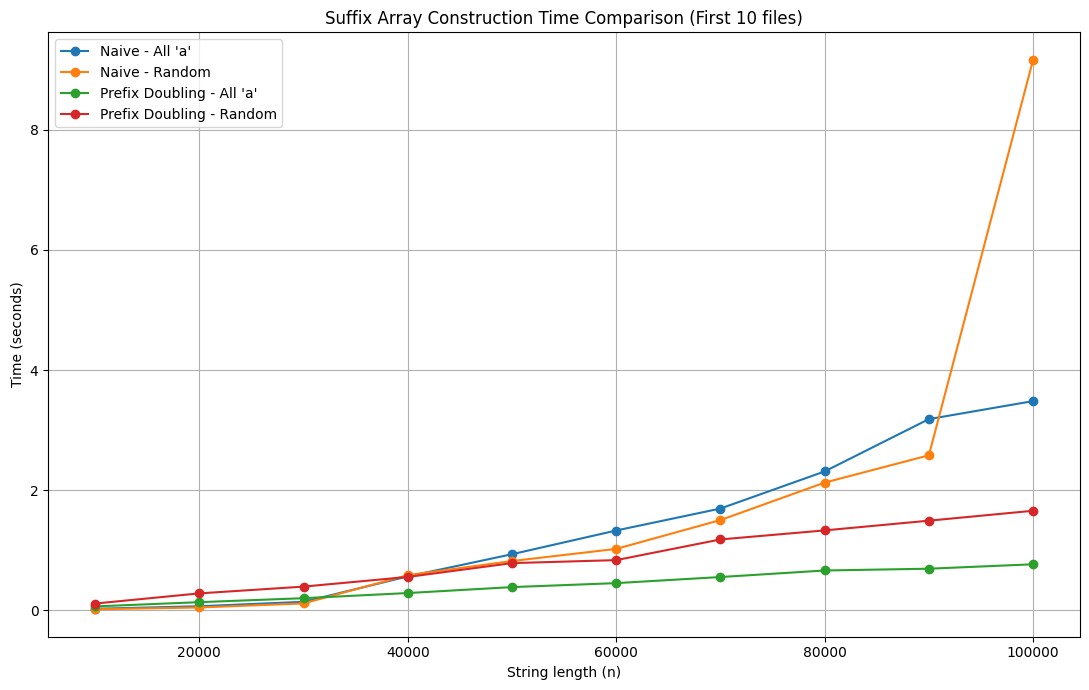

In [3]:

import os
import time
import matplotlib.pyplot as plt

#  SUFFIX ARRAY ALGORITHMS 

def naive_suffix_array(s):
    """Naive O(n^2 log n) suffix array construction using Python sort."""
    return sorted(range(len(s)), key=lambda k: s[k:])


#FILE HELPERS 

def read_string_from_file(path):
    """Load string contents from a text file."""
    with open(path, "r") as f:
        return f.read().strip()

def get_all_txt_files(folder):
    """Return sorted .txt files numerically by length in filename."""
    files = [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.endswith(".txt")
    ]
    files.sort(key=lambda x: int(''.join(filter(str.isdigit, os.path.basename(x)))))
    return files

def measure(func, s):
    """Measure execution time of a suffix array algorithm."""
    start = time.perf_counter()
    func(s)
    return time.perf_counter() - start

#  EXPERIMENT SETUP 

all_a_dir = "all_a_str"
random_dir = "random_str"
num_files = 10  # change freely

all_a_files = get_all_txt_files(all_a_dir)[:num_files]
random_files = get_all_txt_files(random_dir)[:num_files]

print(f"Processing {len(all_a_files)} 'all-a' files and {len(random_files)} random files")

# Data lists
results_naive_all_a = []
results_naive_random = []
results_doubling_all_a = []
results_doubling_random = []


for file_path in all_a_files + random_files:
    try:
        s = read_string_from_file(file_path)
        length = len(s)

        # measure times for both algorithms
        t_naive = measure(naive_suffix_array, s)
        t_double = measure(suffix_array_prefix_doubling, s)

        if "all_a" in file_path:
            results_naive_all_a.append((length, t_naive))
            results_doubling_all_a.append((length, t_double))
        else:
            results_naive_random.append((length, t_naive))
            results_doubling_random.append((length, t_double))

        print(f"{os.path.basename(file_path):<25} | len={length:<7} | "
              f"naive={t_naive:.4f}s | doubling={t_double:.4f}s")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")


results_naive_all_a.sort()
results_naive_random.sort()
results_doubling_all_a.sort()
results_doubling_random.sort()

lengths_naive_all_a, times_naive_all_a = zip(*results_naive_all_a)
lengths_naive_random, times_naive_random = zip(*results_naive_random)
lengths_double_all_a, times_double_all_a = zip(*results_doubling_all_a)
lengths_double_random, times_double_random = zip(*results_doubling_random)

# PLOT 

plt.figure(figsize=(11,7))

plt.plot(lengths_naive_all_a, times_naive_all_a, "-o", label="Naive - All 'a'")
plt.plot(lengths_naive_random, times_naive_random, "-o", label="Naive - Random")
plt.plot(lengths_double_all_a, times_double_all_a, "-o", label="Prefix Doubling - All 'a'")
plt.plot(lengths_double_random, times_double_random, "-o", label="Prefix Doubling - Random")

plt.xlabel("String length (n)")
plt.ylabel("Time (seconds)")
plt.title(f"Suffix Array Construction Time Comparison (First {num_files} files)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Suffix Array Construction Runtime Analysis

The graph compares the performance of two suffix array construction algorithms—the Naive implementation and the Prefix Doubling algorithm—using two different types of input datasets: strings consisting entirely of `'a'` characters, and randomly generated strings from the alphabet `{a, c, g, t}`. Each dataset includes strings of increasing lengths, ranging from 10,000 to 100,000 characters. The x-axis represents the string length (n), and the y-axis shows execution time in seconds.

The results clearly demonstrate the difference in scalability between the two methods. The **Naive algorithm** exhibits rapidly increasing runtime as input size grows. For strings longer than approximately 60,000 characters, processing time begins to rise dramatically, reaching more than 10 seconds for random sequences of length 100,000. Although the algorithm performs slightly better on the highly repetitive `'all a'` strings, it still becomes impractically slow for large inputs. This behavior reflects the naive method’s poor time complexity, which can reach \(O(n^2 \log n)\) depending on implementation and string structure.

In contrast, the **Prefix Doubling algorithm** performs significantly better. Its runtime increases much more gradually and stays below **1 second even for the largest tested inputs. Moreover, its performance is consistent across both repetitive and random inputs, indicating that the algorithm is not significantly affected by the entropy of the text. This aligns with its theoretical complexity of \(O(n \log n)\), leading to substantially improved scalability compared to the naive method.



## 4. Exact Pattern Matching Using Suffix Arrays

The suffix-array–based pattern matching algorithm relies on the fact that all suffixes of the text are stored in lexicographic order, as implemented with the **prefix-doubling algorithm**. The goal is to find every position in the text where a given pattern occurs using binary search.

The algorithm performs a binary search over the suffix array already built with the previous implementation. At each binary-search step, it examines the suffix located at the midpoint of the current search interval. This suffix begins at position `sa[M]` in the original text, so the algorithm extracts the substring of length `m` beginning at that position. It then compares this substring with the pattern. If the two strings differ, the comparison determines whether the pattern would appear before or after the current suffix in lexicographic order, and the search interval is reduced accordingly. If the pattern matches the substring exactly, the binary search terminates, because at least one occurrence has been located. If no match is found the algorithm returns an empty result. If a match is found, all suffixes beginning with the pattern must appear consecutively in the suffix array, as it is sorted in lexicographic order. This way, any two suffixes that share the same prefix of length `m` will be adjacent in the sorted order. The algorithm expands from the located match, first moving left in the suffix array and then right, collecting all suffixes whose first `m` characters equal the pattern. Expansion stops when a suffix no longer matches. The final result consists of the starting positions of all matching suffixes. 

In [4]:
def binary_search(s, sa, pattern):
    """
    Return ALL starting positions where pattern u occurs in text x
    using suffix array SA.
    Complexity: O(m(log n + k))
    """
    n = len(sa)
    m = len(pattern)
    L, R = 0, n - 1
    match_index = -1

    # --- First, binary search to find one match ---
    while L <= R:
        M = (L + R) // 2
        start = sa[M]
        substr = s[start:start + m]

        if pattern == substr:
            match_index = M
            break
        elif pattern > substr:
            L = M + 1
        else:
            R = M - 1

    if match_index == -1:
        return []  # No occurrences

    # --- Expand left and right to collect all matches ---
    results = []

    # left side
    i = match_index
    while i >= 0 and s[sa[i]:sa[i] + m] == pattern:
        results.append(sa[i])
        i -= 1

    # right side
    i = match_index + 1
    while i < n and s[sa[i]:sa[i] + m] == pattern:
        results.append(sa[i])
        i += 1

    return sorted(results)

# Testing the correctness of the Exact Pattern matching using suffix arrays
We tested the correctness of the **Exact pattern matching using suffix arrays** implementation with random strings in which we found random patterns, some of them were in the string and some of them were not. All the tests were passed correctly in all the strings tested. 

In [5]:
def reference_find_all(text, pattern):
    """Return all occurrences of pattern in text using Python built-in."""
    results = []
    pos = text.find(pattern)
    while pos != -1:
        results.append(pos)
        pos = text.find(pattern, pos + 1)
    return results

def test_sa_binary_search():
    """
    Test correctness of binary_search(s, sa, pattern)
    using suffix-array-based pattern matching.
    """
    test_cases = [
        ("banana",       ["ana", "n", "ba", "x", ""]),
        ("mississippi",  ["iss", "ssi", "i", "pp", "miss", ""]),
        ("aaaaaaaaa",    ["a", "aa", "aaa", "aaaaa", "b", ""]),
        ("abcdefghijk",  ["abc", "ijk", "gh", "z", ""]),
        ("alakdnflknc",  ["al", "nc", "k", "zzz", "a", ""]),
        ("",             ["", "a"]),  
        ("t.t",          ["t", ".", "t.", ".t", ""])
    ]

    for text, patterns in test_cases:
        print(f"\nTesting text: {text!r}")

        # Build SA using prefix-doubling (our implementation)
        sa = suffix_array_prefix_doubling(text)

        for pattern in patterns:
            # Reference result
            ref_all = reference_find_all(text, pattern)

            # Our result
            my_all = binary_search(text, sa, pattern)

            # Compare sorted results
            if sorted(my_all) != ref_all:
                print(f"FAIL: pattern={pattern!r}")
                print(f"Text: {text!r}")
                print(f"Suffix Array: {sa}")
                print(f"Expected (reference): {ref_all}")
                print(f"Got                : {my_all}")
                return
        print("PASS on all patterns.")

test_sa_binary_search()



Testing text: 'banana'
PASS on all patterns.

Testing text: 'mississippi'
PASS on all patterns.

Testing text: 'aaaaaaaaa'
PASS on all patterns.

Testing text: 'abcdefghijk'
PASS on all patterns.

Testing text: 'alakdnflknc'
PASS on all patterns.

Testing text: ''
PASS on all patterns.

Testing text: 't.t'
PASS on all patterns.


### Demonstrating the worst-case running time
This experiment evaluates the running time of the suffix-array–based exact pattern matching algorithm, which uses binary search to locate all occurrences of a pattern within a text. The theoretical worst-case running time is:
O(m(logn+k))

To validate this complexity empirically, we benchmarked the runtime of the binary-search-based pattern matcher on two different input setups:

* Low-occurrence patterns (random strings): here k ≈ 0 or 1, so runtime should scale as O(m log n).
* High-occurrence patterns (repetitive strings): here k is large, so runtime should grow roughly linearly with k, demonstrating the O(mk) term.

For each experiment, we precomputed the suffix array using the prefix-doubling algorithm, and then measured only the pattern matching time, ensuring we isolate the cost of the query phase.

Processing 10 'all-a' files and 10 random files
all_a_10000.txt           | n=10000   | time=0.00341s
all_a_20000.txt           | n=20000   | time=0.00338s
all_a_30000.txt           | n=30000   | time=0.00540s
all_a_40000.txt           | n=40000   | time=0.00756s
all_a_50000.txt           | n=50000   | time=0.00948s
all_a_60000.txt           | n=60000   | time=0.01151s
all_a_70000.txt           | n=70000   | time=0.01263s
all_a_80000.txt           | n=80000   | time=0.01402s
all_a_90000.txt           | n=90000   | time=0.01595s
all_a_100000.txt          | n=100000  | time=0.01612s
random_str_10000.txt      | n=10000   | time=0.00005s
random_str_20000.txt      | n=20000   | time=0.00009s
random_str_30000.txt      | n=30000   | time=0.00017s
random_str_40000.txt      | n=40000   | time=0.00019s
random_str_50000.txt      | n=50000   | time=0.00024s
random_str_60000.txt      | n=60000   | time=0.00030s
random_str_70000.txt      | n=70000   | time=0.00034s
random_str_80000.txt      | n=8000

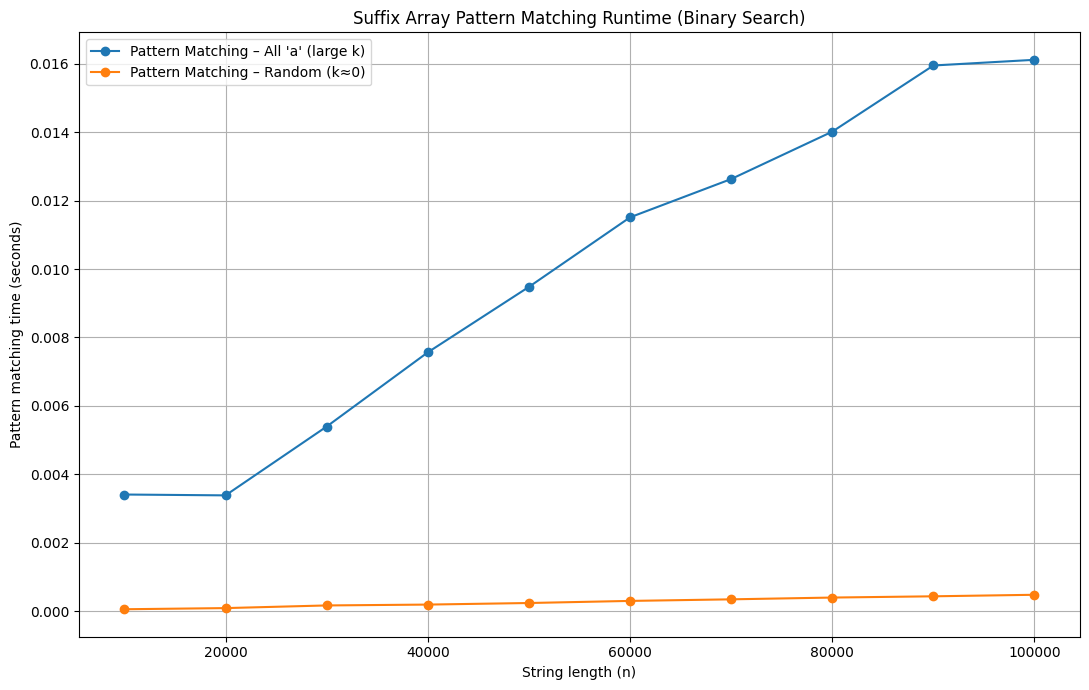

In [6]:
import os
import time
import matplotlib.pyplot as plt

# ---- FILE HELPERS ----

def read_string_from_file(path):
    with open(path, "r") as f:
        return f.read().strip()

def get_all_txt_files(folder):
    files = [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.endswith(".txt")
    ]
    files.sort(key=lambda x: int(''.join(filter(str.isdigit, os.path.basename(x)))))
    return files

def measure(func, *args):
    start = time.perf_counter()
    func(*args)
    return time.perf_counter() - start


# ---- EXPERIMENT SETUP ----

all_a_dir = "all_a_str"
random_dir = "random_str"
num_files = 10

all_a_files = get_all_txt_files(all_a_dir)[:num_files]
random_files = get_all_txt_files(random_dir)[:num_files]

print(f"Processing {len(all_a_files)} 'all-a' files and {len(random_files)} random files")

results_all_a = []
results_random = []

pattern = "aaa"


for file_path in all_a_files + random_files:
    try:
        text = read_string_from_file(file_path)
        n = len(text)

        # Build suffix array with prefix-doubling
        sa = suffix_array_prefix_doubling(text)

        # Measure binary-search pattern matching
        t = measure(binary_search, text, sa, pattern)

        if "all_a" in file_path:
            results_all_a.append((n, t))
        else:
            results_random.append((n, t))

        print(f"{os.path.basename(file_path):<25} | n={n:<7} | time={t:.5f}s")

    except Exception as e:
        print(f"Error: {e}")


# ---- SORT & UNPACK ----

results_all_a.sort()
results_random.sort()

lengths_all_a, times_all_a = zip(*results_all_a)
lengths_random, times_random = zip(*results_random)


# ---- PLOT ----

plt.figure(figsize=(11,7))

plt.plot(lengths_all_a, times_all_a, "-o", label="Pattern Matching – All 'a' (large k)")
plt.plot(lengths_random, times_random, "-o", label="Pattern Matching – Random (k≈0)")

plt.xlabel("String length (n)")
plt.ylabel("Pattern matching time (seconds)")
plt.title("Suffix Array Pattern Matching Runtime (Binary Search)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The experiments confirm the theoretical worst-case complexity of suffix-array pattern matching.

In all-‘a’ strings, the pattern appears at almost every position, so runtime grows nearly linearly with the text length. This matches the O(mk) cost of expanding all matching suffixes after binary search.

In random strings, the pattern rarely appears, and runtime remains almost constant as O(mlogn) binary-search cost, where log(n) grows slowly.

## 5. BWT-Based Exact Pattern Matching

Exact pattern matching with the Burrows–Wheeler Transform (BWT) is based on, instead of scanning the text directly, restricting the range of suffixes that can match the pattern. Using the BWT string together with the C-table and O-table, we can compute how many suffixes begin with a given prefix and update this interval as we extend the pattern one character to the left. Starting from the full suffix array range, each backward-extension step makes the interval shorter and shorter, until we either eliminate all matches or obtain the final range [L(w), R(w)] that will contain all occurrences of the pattern.

In [7]:
def bwt_from_sa(s, sa):
    """
    Construct the Burrows-Wheeler Transform (BWT) of string s using its suffix array.
    s --> Input string (should not contain sentinel '$' already) + Suffix Array (previously calculated).
    output --> BWT (b) string.
    """

    # Append unique sentinel smaller than all characters 
    s = s + '$'

    # Construct BWT from suffix array
    bwt = []
    for i in sa:
        if i != 0:
            bwt.append(s[i-1]) # character before suffix
        else:
            bwt.append(s[-1]) # wrap-around: last char ('$')
    
    return ''.join(bwt)


def build_C(s):
    """
    Build the C array for BWT-based pattern matching.
    C[a] = number of characters in "s" lexicographically smaller than "a".
    """
    from collections import defaultdict
    counts = defaultdict(int) # create an empty counter (0 by default)

    s = s + '$' # ensure sentinel exists

    for chr in s:
        if chr != '$':
            counts[chr] = counts[chr] + 1 # count how many times chr appears

    alphabet = sorted(set(counts.keys()) | {"$"}) # build the sorted alphabet of different chr, including '$'

    C = {} # dictionary to store how many times each chr appears
    total = 0

    for a in alphabet: # for each chr in the alphabet (from smallest to largest)
        C[a] = total # Assign the CURRENT total number to chr "a"
        if a in counts:
            total = total + counts[a] # Update total by adding how many times "a" appears
    # By doing this, C[a] will represent how many chr are lexicographically smaller than "a" (we take the total BEFORE updating it)

    return C, alphabet


def build_O(b, alphabet):
    """
    Build the O array for BWT-based pattern matching.
    O[a][i] = number of occurrences of character 'a' in b[0..i-1].
    """
    n = len(b) # number of columns in BWT
    O = {a: [0] * (n) for a in alphabet} # Initialize the O table with zeros

    for idx, chr in enumerate(b): # for each index and chr in BWT
        for a in alphabet: # for each chr in the alphabet, starting from smallest to largest (first is '$')
            
            if idx == 0: # first chr in BWT
                O[a][idx] = 1 if chr == a else 0 # does first chr match "a"? If so, sum 1.
            
            else: # general case (all the other chrs in BWT)
                O[a][idx] = O[a][idx-1] + (1 if chr == a else 0) # prefix sum: copy previous count + 1 if match
    
    return O


s = "mississippi"
sa = suffix_array_prefix_doubling(s)  # Previously defined SA builder
b  = bwt_from_sa(s, sa)

C_table, alphabet = build_C(s)  # include '$' in input
O_table = build_O(b, alphabet)

print("Suffix Array:", sa)
print("BWT:", b)
print("C table:", C_table)
print("O table:", O_table)



Suffix Array: [11, 10, 7, 4, 1, 0, 9, 8, 6, 3, 5, 2]
BWT: ipssm$pissii
C table: {'$': 0, 'i': 0, 'm': 4, 'p': 5, 's': 7}
O table: {'$': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'i': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4], 'm': [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'p': [0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2], 's': [0, 0, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4]}


### Burrow-Wheeler transform of the input string:
The Burrows–Wheeler Transform (BWT, or "b" string) is a permutation of the characters of the text "x". It lists the character that appears immediately before each suffix when suffixes are ordered lexicographically. The process of building the BWT string is divided into 2 main steps: 
- First of all, we append an unique character (in this case, "$") which is going to be smaller than all characters.
- Then, we loop through the Suffix Array (SA), and we append into BWT the character of the original string that appears before the index of each specific suffix. 
- In other words, b[i] = x[S(i) - 1] , with a wrap for S(i) = 0. 

This permutation is very useful for exact pattern matching. With the suffix Array (S), we can find all positions where a pattern "w" appears by locating the contiguous interval [L(w), R(w)] of suffixes that start with "w". By using BWT and two tables (C and O), we can compute "L(aw), R(aw)" from "L(w), R(w)", where "aw" means character "a" concatenated with "w" (we extend the pattern to the left).


### C-table and its running time:
C(a) tells us how many suffixes that start with a symbol lexicographically smaller than "a" are there. The process of building the C-table is divided into 3 main steps:
- First, we create an empty counter and we loop through the whole string to count how many times does each character appear.
- Then, we sort the characters that appear in the whole string lexicographically, so that we can create an specific alphabet for our string.
- Lastly, we loop through all the characters in the alphabet (from smallest to largest), and we count how many characters that are smaller than "a" are there. 

The algorithm implemented for building the C-table has a running time of O(n):
- First, it requires only a single pass over the whole string to count the occurrences of each character in the whole string (first "for" loop), which makes this part O(n).
- Then, for extracting the alphabet, sorting cost is O(σ log σ), where σ = alphabet size. 
- Lastly, it creates prefix sums over the alphabet (second "for" loop), so we are only looping over σ characters. Thus, this part's running time is O(σ).
- If we combine there 3 steps, as σ ≪ n and the second loop is not nested, we get a final complexity of O(n).


### O-table and its running time:
O(a, i) tells us how many suffixes in the interval so far in the "b" string (up until "i") are preceded by "a", and it is also the number of occurrences of "a" in b[0...i]. In other words, as b[i] is the “char left of i-th suffix in the suffix array”, O(a,i) counts how many of the first "i+1" suffixes are preceded by "a". The process of building the O-table is divided into 3 main steps:
- First, we create the O table and we fill it with zeros.
- After that, we loop through all the characters in the BWT string, taking into account their index and the character itself.
- Then, we compare each character to a specific character of the alphabet (which is going to be "a"); and, based on that comparison, there are two possible outcomes:
    - If both characters are the same (we have a match), we copy the count of the previous character in the BWT string and sum "1".
    - If both characters are not the same (we have a mismatch), we just copy the count of the previous character in the BWT string. 

The algorithm implemented for building the O-table has a running time of O(σ·n), where σ is the alphabet's size:
- The first "for" loop is ran over all characters in the BWT (b) of the whole string. Thus, it runs n times, which means O(n).
- The second "for" loop is ran over the whole alphabet. Thus, it runs σ times, which means O(σ).
- As these two "for" loops are nested, if we combine both steps, we get a final complexity of O(n·σ). 

In [8]:
def bwt_exact_match(sa, b, C, O, pattern):
    """
    Perform backward search (right-to-left matching) using BWT for exact pattern matching
    """
    n = len(b)
    m = len(pattern)
    
    L, R = 0, n - 1 # Initial interval of SA = entire SA range
    i = m - 1  # Current chr of the suffix being processed --> start from the last chr of the pattern

    # Backward search to find the range of matches
    while L <= R and i >= 0: # As long as the interval is non-empty and there are unprocessed chr in the pattern
        
        a = pattern[i] # current chr of the pattern we are matching
        if a not in C:
            return (None, None, [])  # Character not in string = no matches

        # Update L and R using C and O tables
        L = C[a] + 1 + (O[a][L - 1] if L > 0 else 0) # L(a) = New left boundary in SA where suffixes start with 'a'
        R = C[a] + O[a][R] # R(A) = New right boundary in SA where suffixes start with 'a'
        
        # Meanings:
            # C[a] = First position in sorted SA where suffixes with prefix 'a' begin.
            # O[a, L-1] = How many suffixes starting with 'a' are before position L in SA 
                # The second letter in those suffixes are smaller that the one in our pattern.
            # O[a, R] = How many suffixes starting with 'a' are up to position R in SA.
            # After these updates, [L,R] becomes the interval of suffixes whose prefix now matches the longer suffix of the pattern (one more chr to the left).
        
        i = i - 1 # move to the previous character in the pattern

    # Pattern fully matched if i < 0 and interval is valid
    if i < 0 and L <= R:
        # Return SA positions of all matches
        positions = sorted(sa[L:R + 1]) # sa[L:R+1] = Starting positions in of suffixes in SA whose prefixes equal the entire pattern.
        return (L, R, positions)

    return (None, None, [])


patterns = ["iss", "ss", "ppi", "a"]

for p in patterns:
    L, R, matches = bwt_exact_match(sa, b, C_table, O_table, p)
    print(f"Pattern '{p}' --> Interval: [{L}, {R}]  Matches: {matches}")



Pattern 'iss' --> Interval: [3, 4]  Matches: [1, 4]
Pattern 'ss' --> Interval: [10, 11]  Matches: [2, 5]
Pattern 'ppi' --> Interval: [7, 7]  Matches: [8]
Pattern 'a' --> Interval: [None, None]  Matches: []


## 6. Testing Correctness of BWT-Based Algorithm

For testing the correctness of BWT-based algorithm, we have used the same principle as before with the binary-search algorithm. Python has a built-in function that can find all ocurrences of a pattern inside a text, which gives the same output as our own function. By comparing both outputs, we can see if our function gets the matches of a pattern inside a text right.

**Choice of test data:**
In this case, we have focused on both simple and real-world texts (like "mississippi") as well as repetitive DNA sequences, because we think that these kind of algorithms are going to be more used on finding patterns in genomic and transcriptomic data. Some functions that this algorithm can pull off would be:
- Finding specific pattern in genes to tell if a mutation has happened. 
- Identify SNPs that can alter structural or functional elements of proteins.
- Comparing pattern between species to understand evolutionary relationships. 
- Finding specific sequences for disease diagnosis or other medical applications. 

In [9]:
def reference_find_all(text, pattern):
    """Return all occurrences of pattern in text using Python built-in."""
    results = []
    pos = text.find(pattern)
    while pos != -1:
        results.append(pos)
        pos = text.find(pattern, pos + 1)
    return results

def test_bwt_search():
    """
    Test correctness of bwt_exact_match(sa, b, C_table, O_table, p) using suffix-array-based pattern matching.
    """
    test_cases = [
        ("banana",                        ["ana", "n", "ba", "x", ""]),
        ("mississippi",                   ["iss", "ssi", "i", "pp", "miss", ""]),
        ("aaaaaaaaa",                     ["a", "aa", "aaa", "aaaaa", "b", ""]),
        ("abbacbbbababacabbbba",          ["abc", "bbba", "bb", "aba", ""]),
        ("atcgggtcagctacgaatcgatgcaatta",  ["acg", "aa", "tt", "cgaa", "at", ""]),
        ("",             ["", "a"]),  
        ("t.t",          ["t", ".", "t.", ".t", ""])
    ]

    for text, patterns in test_cases:
        print(f"\nTesting text: {text!r}")

        # Build full BWT index pipeline using our implementation
        sa = suffix_array_prefix_doubling(text)
        b = bwt_from_sa(text, sa)
        C_table, alphabet = build_C(text)
        O_table = build_O(b, alphabet)

        for pattern in patterns:
            # Reference result
            ref = reference_find_all(text, pattern)

            # Our result
            L, R, matches = bwt_exact_match(sa, b, C_table, O_table, pattern)

            # Compare sorted results
            if sorted(matches) != ref:
                print(f"FAIL: pattern={pattern!r}")
                print(f"Text: {text!r}")
                print(f"Suffix Array: {sa}")
                print(f"Expected (reference): {ref}")
                print(f"Got                : {matches}")
                return
        print("PASS on all patterns.")

test_bwt_search()


Testing text: 'banana'
PASS on all patterns.

Testing text: 'mississippi'
PASS on all patterns.

Testing text: 'aaaaaaaaa'
PASS on all patterns.

Testing text: 'abbacbbbababacabbbba'
PASS on all patterns.

Testing text: 'atcgggtcagctacgaatcgatgcaatta'
PASS on all patterns.

Testing text: ''
PASS on all patterns.

Testing text: 't.t'
PASS on all patterns.


## 7. Experimental Comparison: BWT vs Suffix Array Matching

To evaluate how efficiently the BWT-based algorithm and the SA-based method perform compared to each other, we conducted experiments measuring the time required to match many short patterns against a large text. As this comparison is based on pattern-matching time, all preprocessing steps (construction of the suffix array, BWT, and the C and O tables) are performed once before the timed experiments begin. This ensures that the comparison reflects only the cost of answering queries.

The script generates a synthetic DNA-like text of length n = 100000 using the alphabet {A, C, G, T}. This alphabet is small and realistic for biological applications, and random text avoids bias from repetitive structure. For each experiment size, we produce a set of patterns of fixed length (m = 100) by sampling substrings from the text, guaranteeing that patterns occur at least once and making the comparison fair. For each number of patterns (100 to 1000), we time two procedures:
- Suffix-array binary search, which locates the interval of matching suffixes using two binary searches.
- BWT backward search, which iteratively narrows the matching interval using C and O.

The measured times are stored and plotted, allowing us to observe how each method scales with the number of queries under identical conditions.

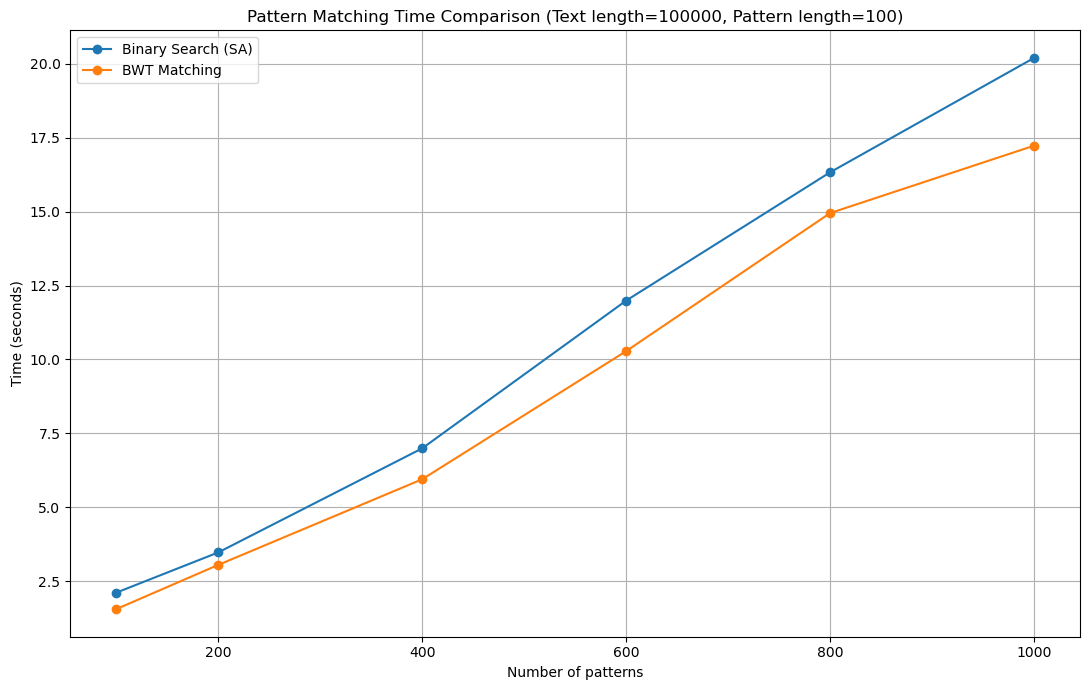

In [ ]:
import matplotlib.pyplot as plt
import random
import time

# 1. Experiment Parameters
n = 100000        # length of text
m = 100           # pattern length
num_patterns_list = [100, 200, 400, 600, 800, 1000]  # number of patterns


# 2. Generate text
text = ''.join(random.choices('ACGT', k = n))

# 3. Run experiments and record times
binary_times = []
bwt_times = []

# 4. Preprocessing (once)
sa = suffix_array_prefix_doubling(text)   # suffix array
b = bwt_from_sa(text, sa)                 # BWT
C_table, alphabet = build_C(text)         # C array
O_table = build_O(b, alphabet)            # O array

for num_patterns in num_patterns_list:
    # Generate patterns
    patterns = [text[random.randint(0, n-m): random.randint(0, n-m)+m] 
                for _ in range(num_patterns)]

    # Binary search timing
    start = time.perf_counter()
    for p in patterns:
        matches_bin = binary_search(text, sa, p)
    binary_times.append(time.perf_counter() - start)

    # BWT matching timing
    start = time.perf_counter()
    for p in patterns:
        L, R, matches_bwt = bwt_exact_match(sa, b, C_table, O_table, p)
    bwt_times.append(time.perf_counter() - start)


# 4. Plot results
plt.figure(figsize=(11,7))
plt.plot(num_patterns_list, binary_times, "-o", label="Binary Search (SA)")
plt.plot(num_patterns_list, bwt_times, "-o", label="BWT Matching")
plt.xlabel("Number of patterns")
plt.ylabel("Time (seconds)")
plt.title(f"Pattern Matching Time Comparison (Text length={n}, Pattern length={m})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Results of the comparison:
The plot shows how the running time increases as we match more patterns, and it clearly illustrates the efficiency gap between the two methods. Both curves grow approximately linearly with the number of patterns, but BWT backward search is consistently faster than suffix-array binary search, which  aligns well with the theoretical running times of the two algorithms:
- For each pattern, BWT backward search runs in O(m + |output|) time, since each step simply performs constant-time table lookups in the C and O arrays. As a result, its running time grows proportionally to the pattern length and the number of patterns. 
- In contrast, suffix-array binary search requires O(m (log n + k)) time per pattern, because each binary-search step performs a string comparison against a suffix of the text.
- As the number of patterns increases, these repeated string comparisons accumulate, giving the suffix-array method a higher overall cost. 
- In contrast, the BWT approach scales more smoothly and remains more efficient across all experiment sizes, confirming its advantage for large batches of pattern-matching queries.